In [1]:
import torch
import torch.nn as nn
import numpy as np
import os

from matplotlib import pyplot as plt
from constants import REPO_DIR
from utils import get_saved_model, NormalizeImage

In [3]:
class ReparameterizationAndLossBlock(nn.Module):
  """
  Implemented this way so that the VAE encoder can output the latent sampled z
  while simultaneously computing KL divergence for downstream use and making this
  divergence available to the VAE (parent) module.
  This allows the VAE to conform to the generic x -> encoder -> z -> decoder -> x'
  expected by the util functions
  """
  def __init__(self, parent):
    super().__init__()
    #note, we cannot set self.parent = parent - this will result in an infinite recursion error
    #instead, we pass in a lambda allowing this block to update the kl_divergence attribute of its parent
    self.update_kl_divergence = lambda kl_divergence: parent.update_kl_divergence(kl_divergence)
    self.pre_latent_dim = parent.pre_latent_dim
    self.latent_dim = parent.latent_dim
    self.latent_to_mu = nn.Linear(self.pre_latent_dim, self.latent_dim)
    self.latent_to_logvar = nn.Linear(self.pre_latent_dim, self.latent_dim)
    self.normal = torch.distributions.Normal(0, 1)

  def forward(self, x):
    mu = self.latent_to_mu(x)
    logvar = self.latent_to_logvar(x)
    z = mu + torch.exp(logvar / 2) * self.normal.sample((self.latent_dim,))
    kl_divergence = 0.5*torch.sum(torch.exp(logvar) + torch.pow(mu, 2) - 1 - logvar)
    self.update_kl_divergence(kl_divergence)
    return z

class VariationalAutoEncoder(nn.Module):

  def __init__(self):
    super().__init__()
    self.pre_latent_dim = 128
    self.latent_dim = 16

    self.encoder = nn.Sequential(
        nn.Conv2d(1, 8, 3, stride=2, padding=1),
        nn.ReLU(True),
        nn.Conv2d(8, 16, 3, stride=2, padding=1),
        nn.BatchNorm2d(16),
        nn.ReLU(True),
        nn.Conv2d(16, 32, 3, stride=2, padding=0),
        nn.ReLU(True),
        nn.Flatten(start_dim=1),
        nn.Linear(3 * 3 * 32, self.pre_latent_dim),
        nn.ReLU(True),
        ReparameterizationAndLossBlock(self)
    )

    self.decoder = nn.Sequential(
        nn.Linear(self.latent_dim, self.pre_latent_dim),
        nn.ReLU(True),
        nn.Linear(self.pre_latent_dim, 3 * 3 * 32),
        nn.ReLU(True),
        nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3)),
        nn.ConvTranspose2d(32, 16, 3, 
        stride=2, output_padding=0),
        nn.BatchNorm2d(16),
        nn.ReLU(True),
        nn.ConvTranspose2d(16, 8, 3, stride=2, 
        padding=1, output_padding=1),
        nn.BatchNorm2d(8),
        nn.ReLU(True),
        nn.ConvTranspose2d(8, 1, 3, stride=2, 
        padding=1, output_padding=1)
    )
  
  def update_kl_divergence(self, kl_divergence):
    self.kl_divergence = kl_divergence

  def forward(self, x):
    """
    @returns: reconstructed input, latent dist. mean, latent dist. variance (for downstream KL computation)
    """
    z = self.encoder(x)
    x = self.decoder(z)
    return torch.sigmoid(x)

In [5]:
from utils import mnist_training_set

def retrain_model():
    """
    @returns: retrains new model
    """
    dataloader = torch.utils.data.DataLoader(mnist_training_set, batch_size=32, shuffle=False)
    num_epochs = 5
    batch_size = 32
    model = VariationalAutoEncoder().cpu()
    optimizer = torch.optim.Adam(model.parameters(),weight_decay=1e-5)
    for epoch in range(num_epochs):
        for data in dataloader:
            #note, img from dataloader has dimensions 32x28x28 (batch size is 32)
            #Conv2d input shape is 32x1x28x28 (batch_size x num_channels x width x height)
            img, _ = data
            img = img.reshape(batch_size, -1, 28, 28)
            img = torch.autograd.Variable(img).cpu()
            # ===================forward=====================
            output = model(img)
            loss = model.kl_divergence + nn.functional.binary_cross_entropy(output, img, reduction='sum')
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.item()))
    return model.eval()
    

In [6]:
VAE_MNIST_WEIGHT_PATH = os.path.join(REPO_DIR, 'architectures', 'weights', 'vae_state_dict.pt')

def save_model(model, weight_path=VAE_MNIST_WEIGHT_PATH):
    """
    @param model: model to save
    @param weight_path: path to save weights to
    """
    if not os.path.isfile(weight_path):
        os.makedirs(os.path.dirname(weight_path), exist_ok = True)
    torch.save(model.state_dict(), weight_path)


def load_saved_model(weight_path=VAE_MNIST_WEIGHT_PATH):
    """
    @param weight_path: points to path where weights are stored to load model
    @returns: Trained model
    @throws: Exception if no weights stored at weight_path
    """
    return get_saved_model(VariationalAutoEncoder, weight_path)

In [7]:
model = retrain_model()

epoch [1/5], loss:4841.4990
epoch [2/5], loss:4206.6455
epoch [3/5], loss:4064.7937
epoch [4/5], loss:3931.7759
epoch [5/5], loss:3711.2305


In [8]:
save_model(model)

### Results and Interpolation

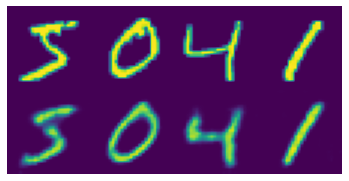

In [9]:
from utils import show_examples

#examples of reconstruction
show_examples(model, 4)

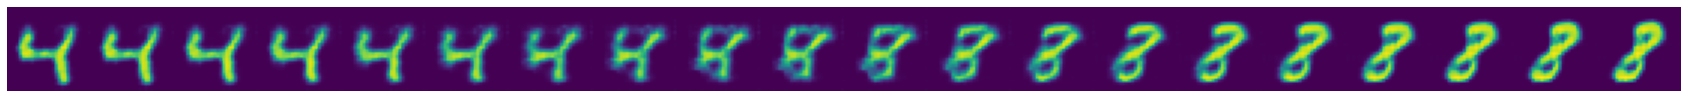

In [10]:
from utils import get_img, display_interpolation_by_idx

display_interpolation_by_idx(model, 2, 31, 20)